# tinycodec

This notebook will track my experiments with video encoding and developing the tinycodec software/hardware codec. This will just be a couple of experiments playing around with compression ideas.

The tinycodec experiments are inspired by [1], which is a great book explaining the details of video compression. tinycodec also takes inspiration from [pfv](https://github.com/GlaireDaggers/Pretty-Fast-Video), which is a toy video codec written in Rust.

[1] Iain Richardson, *H.264 and MPEG-4 Video Compression: Video Coding for Next-generation Multimedia*, John Wiley & Sons, 2003.

In [80]:
import ffmpeg
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
from scipy.fft import dct
from IPython.display import Math
from IPython.display import display

%matplotlib inline

## Part 1: Introduction

Below is a standard DPCM/DCT model for video codecs. The DPCM/DCT model underlies many video coding standards including H.263, H.264, MPEG-2, MPEG-4, and H.265.

<div align="center">
<img src="./data/intro.png" width="750"/>
</div>

In [2]:
probe = ffmpeg.probe('data/test.mov')
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])

In [3]:
def frame(i):
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

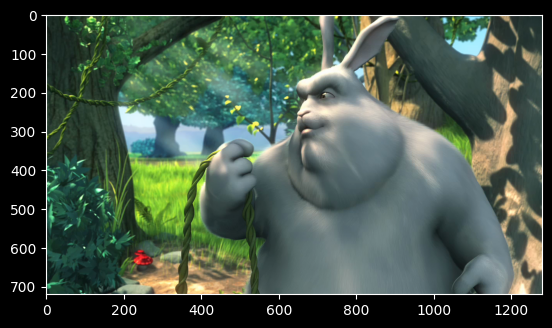

In [4]:
frame1 = frame(249)

plt.imshow(frame1)
plt.show();

## Part 2: Color Space Conversion

The human visual system (HVS) is less sensitive to colour than to luminance (brightness). In the RGB colour space the three colours are equally important and so are usually all stored at the same resolution but it is possible to represent a colour image more efficiently by separating the luminance from the colour information and representing luma with a higher resolution than colour.

We will use the following conversion matrix to convert from RGB space to YUV space:

$$\begin{bmatrix}
Y\\
U\\
V
\end{bmatrix} =
\begin{bmatrix}
0.299 & 0.587 & 0.114 \\
-0.1687 & -0.3313 & 0.5 \\
0.5 & -0.4187 & -0.0813
\end{bmatrix}
\begin{bmatrix}
R\\
G\\
B
\end{bmatrix}$$

In [5]:
def rgb2yuv(rgb):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = rgb.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [6]:
def plot_yuv(y,u,v):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].imshow(u, label='U', cmap='Blues')
    ax[1].title.set_text('U')
    ax[2].imshow(v, label='V', cmap='Reds')
    ax[2].title.set_text('V')
    plt.show()

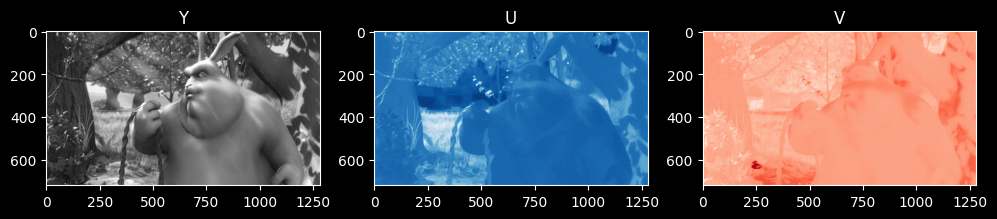

In [7]:
frame1_yuv = rgb2yuv(frame1)
plot_yuv(y=frame1_yuv[:,:,0],u=frame1_yuv[:,:,1],v=frame1_yuv[:,:,2])

## Part 3: Chroma Subsampling

Chroma subsampling is the practice of encoding images by implementing less resolution for chroma information than for luma information, taking advantage of the human visual system's lower acuity for color differences than for luminance.

It is used in many video and still image encoding schemes – both analog and digital – including in JPEG encoding. 

For tinycodec, we will use a 4:2:0 chroma subsampling ratio such that the U and V planes are half the size of the Y plane.

In [8]:
def chroma_subsample(yuv):
    y = yuv[:,:,0]
    u = yuv[:,:,1]
    v = yuv[:,:,2]
    ud = u[::2, ::2]
    vd = v[::2, ::2]
    uu = np.repeat(np.repeat(ud, 2, axis=0), 2, axis=1)
    vu = np.repeat(np.repeat(vd, 2, axis=0), 2, axis=1)
    return np.stack((y, uu, vu), axis=-1)

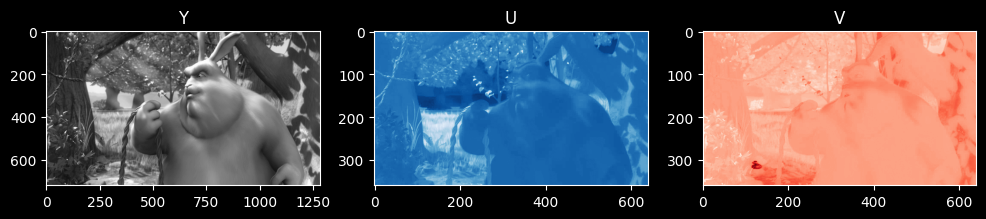

In [9]:
X = chroma_subsample(frame1_yuv)
plot_yuv(y=X[:,:,0],u=X[::2,::2,1],v=X[::2,::2,2])

## Part 4: Discrete Cosine Transform

The **macroblock**, which is a 16x16-pixel region of a frame, is the basic unit on which all of the following transformations rely upon. First, we do motion estimation and compensation based on a prior reference frame. However, for the very first frame (which will be an I-frame), we skip that step. Later on, we will come back to motion estimation + compensation.

In [38]:
def macroblock(x, i, j):
    return x[i*16:(i+1)*16, j*16:(j+1)*16]

In [39]:
def plot_macroblock(mb):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(mb[:,:,0], label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].imshow(mb[:,:,1], label='U', cmap='Blues')
    ax[1].title.set_text('U')
    ax[2].imshow(mb[:,:,2], label='V', cmap='Reds')
    ax[2].title.set_text('V')
    plt.show()

@interact(i=(0, height//16-1), j=(0, width//16-1))
def show_macroblock(i, j):
    mb = macroblock(X, i, j)
    plot_macroblock(mb)

interactive(children=(IntSlider(value=22, description='i', max=44), IntSlider(value=39, description='j', max=7…

In [12]:
mb = macroblock(X, 3, 3)
mb.shape

(16, 16, 3)

The Discrete Cosine Transform (DCT) operates on macroblock $\mathbf{X}$, a block of N × N samples and creates $\mathbf{Y}$, an N × N block
of coefficients. The action of the DCT (and its inverse, the IDCT) can be described in terms of a transform matrix $\mathbf{A}$. The forward DCT (FDCT) of an N × N sample block is
given by:

$$\mathbf{Y} = \mathbf{A}\mathbf{X}\mathbf{A}^\text{T}$$

and the inverse DCT (IDCT) by:

$$\mathbf{X} = \mathbf{A}^\text{T}\mathbf{Y}\mathbf{A}$$

Where the elements of the $\mathbf{A}$ are:

$$A_{ij} = C_i \cos \left( \frac{(2j + 1) i \pi}{2N} \right)$$

where

$$C_i = \begin{cases} \sqrt{\frac{1}{N}} & \text{if } i = 0 \\ \sqrt{\frac{2}{N}} & \text{if } i > 0  \end{cases}$$

In [43]:
def bmatrix(a):
    a = a.round(decimals=4)
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [44]:
def dct_matrix(size):
    return dct(np.eye(size), norm='ortho').T

A = dct_matrix(8)

display(Math(f"\\begin{{align}} \\mathbf{{A}} = {bmatrix(A)} \\end{{align}}"));

<IPython.core.display.Math object>

In [ ]:
def forward_dct(mb):
    """Split macroblock into 8x8 chunks and apply dct on each of them"""
    blocks = []
    A = dct_matrix(8)
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = mb[i:i+8, j:j+8]
            blocks.append(A @ block @ A.T)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

def inverse_dct(mb):
    """Split macroblock into 8x8 chunks and apply inverse dct on each of them"""
    blocks = []
    A = dct_matrix(8)
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = mb[i:i+8, j:j+8]
            blocks.append(A.T @ block @ A)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

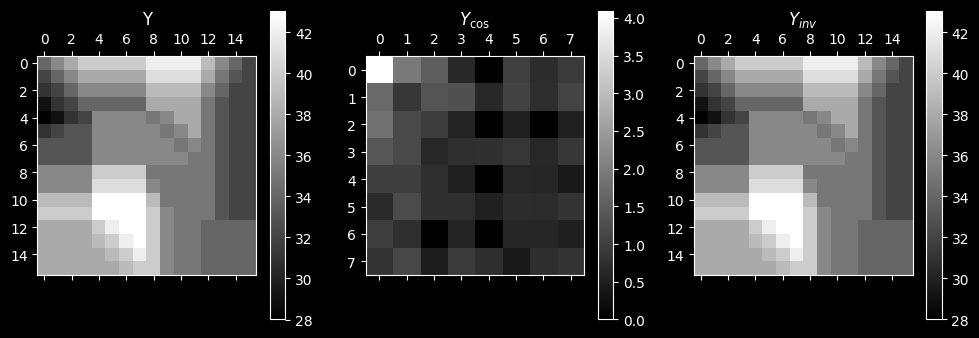

In [108]:
Y = mb[:,:,0]
Y_cos = forward_dct(Y)
Y_inv = inverse_dct(Y_cos)

# Generate side by side subplots
fig, ax = plt.subplots(1,3, figsize=(12,4))
a = ax[0].matshow(Y, label='Y', cmap='grey')
ax[0].title.set_text('Y')
fig.colorbar(a, ax=ax[0])
b = ax[1].matshow(np.abs(Y_cos[0:8,0:8])**(1/4), label='Y_cos', cmap='grey')
fig.colorbar(b, ax=ax[1])
ax[1].title.set_text('$Y_{\\cos}$')
c = ax[2].matshow(Y_inv, label='Y_inv', cmap='grey')
fig.colorbar(c, ax=ax[2])
ax[2].title.set_text('$Y_{inv}$')
plt.show()

## Part 5: Quantization

